# Code Implementation
This file contains the main pipeline for the project.

Additional helper functions and modules can be found under `src/`

## Setup environment (if not done)
1. **Create and activate a virtual environment**\
```bash
python3.11 -m venv .venv
. .venv/bin/activate
```

2. **Install requirements** \
This project uses uv. uv can be installed with `pip install uv`.\
Run to install requirements
```bash
uv sync
```

In [1]:
# Shared imports
import os
import pickle
import shutil
import joblib
import time
import numpy as np
import torch
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", message=".*pin_memory.*")

data_dir = "data/ais/"

## Download the data
The data used in this project is maritime data from automatic identification systems (AIS) obtained obtained from the [Danish Maritime Authority](http://aisdata.ais.dk/). The data is available as a csv file for each day and contains a row for each AIS message with columns such as **Timestamp**, **MMSI**, **Latitude**, **Longitude**, and more. MMSI stands for Maritime Mobile Service Identity and is a unique identifier for a vessel.

For this notebook we use a subset of the data by using data only for 3 days: `2024-05-01`, `2024-05-02`, `2024-05-03`

In [2]:
import requests
import zipfile
import io
from datetime import date, timedelta

def download_ais_data(from_date: date, to_date: date, destination_path: str):
    """Downloads and unzips AIS data for a given date range."""
    
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)
        
    print(f"Starting AIS data download from {from_date} to {to_date} into {destination_path}")

    base_url = "http://aisdata.ais.dk/"
    current_date = from_date
    
    errors = []
    successes = 0
    while current_date <= to_date:
        year = current_date.strftime("%Y")
        month = current_date.strftime("%m")
        day = current_date.strftime("%d")
        
        file_name = f"aisdk-{year}-{month}-{day}.zip" # Construct the file name and URL
        file_url = f"{base_url}{year}/{file_name}"
        
        print(f"Downloading: {file_url}")
        
        try:
            response = requests.get(file_url, stream=True)
            if response.status_code == 200:
                with io.BytesIO(response.content) as zip_buffer:
                    with zipfile.ZipFile(zip_buffer, 'r') as zip_ref:
                        zip_ref.extractall(destination_path)
                        unzipped_files = zip_ref.namelist()
                        assert len(unzipped_files) == 1, "Expected exactly one file in the zip archive."
                        successes += 1
                        
            elif response.status_code == 404:
                print(f"Data not found for {current_date} (404 Error). Skipping.")
                errors.append((current_date, "404 Not Found"))
            else:
                print(f"Failed to download {file_name}. Status code: {response.status_code}")
                errors.append((current_date, f"HTTP {response.status_code}"))
                
        except requests.exceptions.RequestException as e:
            print(f"An error occurred during download for {current_date}: {e}")
            errors.append((current_date, str(e)))
        except zipfile.BadZipFile:
            print(f"Downloaded file for {current_date} is not a valid zip file.")
            errors.append((current_date, "Bad Zip File"))
        except AssertionError as ae:
            print(f"Assertion error for {current_date}: {ae}")
            errors.append((current_date, str(ae)))
        
        current_date += timedelta(days=1)

    if len(errors) == 0:
        print("\nAll files downloaded successfully.")
    else:
        print(f"\nDownload succeeded for {successes}/{(successes + len(errors))} days.")
        print(f"Errors encountered for the following dates:")
        for err_date, err_msg in errors:
            print(f" - {err_date}: {err_msg}")
    print("End of download process.")
    
download_ais_data(date(2024, 5, 1), date(2024, 5, 3), data_dir)

Starting AIS data download from 2024-05-01 to 2024-05-03 into data/ais/
Downloading: http://aisdata.ais.dk/2024/aisdk-2024-05-01.zip
Downloading: http://aisdata.ais.dk/2024/aisdk-2024-05-02.zip
Downloading: http://aisdata.ais.dk/2024/aisdk-2024-05-03.zip

All files downloaded successfully.
End of download process.


## Data preprocessing using MapReduce
Uncompressed, the data for a single day takes up around 3GB of memory and we wish to process 3 months worth of data leading to an infeasible amount of data to keep in memory at one time. However, since the data is time series data and vessel voyages often spans across days, in order to properly preprocess the data we can't process the files in isolation. Secondly, we wish to speed up the wall clock time of preprocessing by efficiently utilizing parallel processing on multiple CPU's running on DTU's High Performance Computing (HPC) cluster. This is where MapReduce comes in.

### Split
We first converts each CSV file individually to dictionaries of arrays grouped by MMSI. The grouped dictionaries are saved as pickle files in a temporary directory. This is the split part of MapReduce.

In [2]:
import polars as pl
from collections import defaultdict
from src.preprocessing.preprocessing import LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, SPEED_MAX as SOG_MAX
from src.preprocessing.csv2pkl import SHIP_TYPE_MAP, NAV_STT_MAP

# Define column indices
LAT, LON, SOG, COG, HEADING, ROT, NAV_STT, TIMESTAMP, MMSI, SHIPTYPE  = list(range(10))

def csv2pkl(input_dir="data/files/",
            output_dir="data/pickle_files"):
    """ Converts raw AIS CSV files to dictionaries grouped by MMSI and saves them as pickle files."""
    
    global LON_MIN, LON_MAX, LAT_MIN, LAT_MAX, SOG_MAX, SHIP_TYPE_MAP, NAV_STT_MAP
      
    l_csv_filename = [filename for filename in os.listdir(input_dir) if filename.endswith('.csv')]
    print(f"Found {len(l_csv_filename)} CSV files in {input_dir}.")
    
    os.makedirs(output_dir, exist_ok=True)
    
    results = {file_name: {"total_messages": 0, "filtered_messages": 0} for file_name in l_csv_filename}

    messages_processed = 0
    unique_vessels = set()
    for csv_filename in tqdm(l_csv_filename, desc=f'Reading csvs'):
        try:
            t_date_str = '-'.join(csv_filename.split('.')[0].split('-')[1:4])
            t_min = time.mktime(time.strptime(t_date_str + ' 00:00:00', "%Y-%m-%d %H:%M:%S"))
            t_max = time.mktime(time.strptime(t_date_str + ' 23:59:59', "%Y-%m-%d %H:%M:%S"))
            
            # Lazy load data using Polars
            lf = pl.scan_csv(os.path.join(input_dir, csv_filename),
                            schema_overrides={
                                "# Timestamp": pl.Utf8,
                                "MMSI": pl.Int64,
                                "Latitude": pl.Float64,
                                "Longitude": pl.Float64,
                                "Navigational status": pl.Utf8,
                                "ROT": pl.Float64,
                                "SOG": pl.Float64,
                                "COG": pl.Float64,
                                "Heading": pl.Int64,
                                "Ship type": pl.Utf8
                            })
            total_messages = lf.select(pl.len()).collect()[0,0]
            messages_processed += total_messages
            results[csv_filename]["total_messages"] = total_messages

            lf = (
                lf.with_columns(
                    pl.col("# Timestamp").str.to_datetime("%d/%m/%Y %H:%M:%S").dt.epoch("s").alias("Timestamp"), # Convert to UNIX timestamp
                    pl.col("Navigational status").replace_strict(NAV_STT_MAP, default=15) # Map navigational status to integers
                ).filter(
                    (pl.col("Latitude") >= LAT_MIN) & (pl.col("Latitude") <= LAT_MAX) &
                    (pl.col("Longitude") >= LON_MIN) & (pl.col("Longitude") <= LON_MAX) &
                    (pl.col("SOG") >= 0) & (pl.col("SOG") <= SOG_MAX) &
                    (pl.col("COG") >= 0) & (pl.col("COG") <= 360) &
                    (pl.col("Timestamp") >= t_min) & (pl.col("Timestamp") <= t_max)
                ).select( # Select only the 9 columns needed for the track + ship type
                    pl.col("Latitude"),
                    pl.col("Longitude"),
                    pl.col("SOG"),
                    pl.col("COG"),
                    pl.col("Heading"),
                    pl.col("ROT"),
                    pl.col("Navigational status"),
                    pl.col("Timestamp"),
                    pl.col("MMSI"),
                    pl.col("Ship type")
                )
            )
                    
            ### Vessel Type Mapping
            vessel_type_dir = os.path.join(output_dir, "vessel_types")
            os.makedirs(vessel_type_dir, exist_ok=True)
            vt_df = (
                lf.with_columns(
                    pl.col("Ship type").replace_strict(SHIP_TYPE_MAP, default=0)
                )
                .filter(pl.col("Ship type") != 0) # "Undefined"
                .group_by("MMSI")
                .agg(
                    pl.col("Ship type").mode().first().alias("VesselType")  # If multiple use the most frequent type
                )
                .collect()
            )
            
            unique_vessels.update(vt_df["MMSI"].to_list())
            
            # Save vessel types mapping
            VesselTypes = {row[0]: row[1] for row in vt_df.iter_rows()}
            vt_output_filename = csv_filename.replace('csv', 'pkl')
            with open(os.path.join(vessel_type_dir, vt_output_filename), "wb") as f:
                pickle.dump(VesselTypes, f)
                
            df = lf.drop("Ship type").collect() # Ship type column no longer needed
            results[csv_filename]["filtered_messages"] = df.height
            
            # Build tracks
            Vs_list = defaultdict(list)
            for row_tuple in tqdm(df.iter_rows(named=False), total=len(df), desc="Building track lists...", leave=False):
                mmsi = row_tuple[MMSI] 
                Vs_list[mmsi].append(row_tuple)
            
            Vs = {} # Final dictionary
            for mmsi, track_list in tqdm(Vs_list.items(), desc="Sorting and converting to NumPy...", leave=False):
                track_list.sort(key=lambda x: x[TIMESTAMP])
                Vs[mmsi] = np.array(track_list, dtype=np.float64)
            
            output_filename = csv_filename.replace('csv', 'pkl') 
            output_path = os.path.join(output_dir, output_filename)
            joblib.dump(Vs, output_path, compress=3)
    
        except Exception as e:
            print(f"Error processing file {csv_filename}: {e}")
        
    print("Conversion completed.")
    
    total_messages = sum(info["total_messages"] for info in results.values())
    total_filtered = sum(info["filtered_messages"] for info in results.values())
    print(f"Total messages processed: {total_messages}")
    print(f"Total messages after filtering: {total_filtered}")
    print(f"Total unique vessels: {len(unique_vessels)}")
    
csv2pkl(input_dir=data_dir, output_dir=f"{data_dir}/pickle_files/")

Found 3 CSV files in data/ais/.


Reading csvs:   0%|          | 0/3 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/15464605 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3963 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/16040042 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3562 [00:00<?, ?it/s]

Building track lists...:   0%|          | 0/15343098 [00:00<?, ?it/s]

Sorting and converting to NumPy...:   0%|          | 0/3891 [00:00<?, ?it/s]

Conversion completed.
Total messages processed: 60839630
Total messages after filtering: 46847745
Total unique vessels: 5022


### Mapping and shuffling
Now that the full dataset has been chunked (split) we map each item (trajectory) based on MMSI to a MMSI directory ready for preprocessing (reduction).

The resulting temporary directory has the structure:\
```
data/
└── temp_dir/
    ├── 123456789/                      # MMSI (unique vessel identifier)
    │   ├── chunk_0001.pkl              # Segment(s) from input_dir
    │   ├── chunk_0002.pkl
    │
    ├── 987654321/
    │   ├── chunk_0001.pkl
    │
    └── ...                             # One folder per MMSI
```

In [3]:
def map_and_shuffle(input_dir: str, temp_dir: str):
    """ Goes through all input files and re-sorts them by MMSI into a temporary directory. """
    
    input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".pkl")] # Input files from chunking step
    
    print(f"Starting map and shuffle phase on {len(input_files)} files...")

    for file_path in tqdm(input_files, desc="Map and Shuffle"):
        data_dict = joblib.load(file_path)
            
        for mmsi, track_segment in data_dict.items():
            
            # Create a directory for this specific MMSI
            mmsi_dir = os.path.join(temp_dir, str(mmsi))
            os.makedirs(mmsi_dir, exist_ok=True)
            
            # Save this segment into the MMSI's folder
            # We name it after the original file to avoid collisions
            segment_filename = os.path.basename(file_path)
            output_path = os.path.join(mmsi_dir, segment_filename)
            
            joblib.dump(track_segment, output_path, compress=3)
    
    print("Map and shuffle phase completed.")

map_and_shuffle(input_dir=f"{data_dir}/pickle_files/", temp_dir=f"{data_dir}/temp_dir/")

Starting map and shuffle phase on 3 files...


Map and Shuffle:   0%|          | 0/3 [00:00<?, ?it/s]

Map and shuffle phase completed.


### Reduce (in parallel)
In the final step of the MapReduce algorithm, the reduction step, we apply preprocessing of the vessel trajectories. As we consider vessels' trajectories as independent from each other, and we have split and shuffled the trajectories by MMSI in the previous step, we are able to perform this step in parallel. 

The preprocessing includes identifying a vessels "voyages". We define a voyage as a contiguous sequence of AIS messages from the same vessel (possible across days), where the time interval between any two consecutive messages does not exceed two hours, and the vessel is actively moving (i.e., not moored or at anchor). See [D. Nguyen, R. Fablet](https://arxiv.org/pdf/2109.03958) for the full preprocessing rules implemented.

The folder structure for the finally preprocessed files will look like:
```
processed/
├── 123456789_0_processed.pkl            # Processed trajectory for MMSI 123456789 (segment 0)
├── 123456789_1_processed.pkl            # (if multiple processed trajectories exist for same MMSI)
├── 987654321_0_processed.pkl
├── 987654321_1_processed.pkl
└── ...
```
where each pickle file constitutes one sample.

In [4]:
from multiprocessing import Pool, cpu_count
from collections import defaultdict
# Multiprocessing requires functions to be importable from a module
# The process_single_mmsi defined below is identical to the one imported here
from src.preprocessing.map_reduce import process_single_mmsi as _process_single_mmsi
from src.preprocessing.preprocessing import preprocess_mmsi_track # Preprocessing rules

def process_single_mmsi(mmsi_info):
    """ Process a single MMSI's track segments. """
    
    mmsi, mmsi_dir_path, final_dir = mmsi_info
    results = {}
    
    # Load all segments for this MMSI
    all_segments = []
    segment_files = [f for f in os.listdir(mmsi_dir_path) if f.endswith(".pkl") and not f.startswith("vessel_types_")]
    if not segment_files:
        return {"error": f"No segment files found for MMSI {mmsi}",
                "error_code": 0}
    for seg_file in segment_files:
            segment_path = os.path.join(mmsi_dir_path, seg_file)
            track_segment = joblib.load(segment_path)
            all_segments.append(track_segment)
    
    results['num_segments'] = len(all_segments)
    
    try: # Merge into one track
        full_track = np.concatenate(all_segments, axis=0)
    except ValueError as e:
        return {"error": f"Error concatenating segments for MMSI {mmsi}: {str(e)}",
                "error_code": 1}

    try: # Run processing for single MMSI's track
        processed_data, preprocessing_results = preprocess_mmsi_track(full_track)
        results.update(preprocessing_results)
    except Exception as e:
        return {"error": f"Error processing track for MMSI {mmsi}: {str(e)}",
                "error_code": 2}
    
    if processed_data: # Save final result
        for k, traj in processed_data.items(): # Constitues a sample
            final_output_path = os.path.join(final_dir, f"{mmsi}_{k}_processed.pkl")
            data_item = {'mmsi': mmsi, 'traj': traj}
            joblib.dump(data_item, final_output_path, compress=3)
            
    return results
    
def reduce(final_dir: str, temp_dir: str, n_workers: int = None, chunk_size: int = 10):
    """ Preprocess vessel trajectories by MMSI in parallel."""
    
    os.makedirs(final_dir, exist_ok=True)
    mmsi_folders = os.listdir(temp_dir)
    
    print(f"Starting reduce phase on {len(mmsi_folders)} MMSI folders")
    
    # Prepare list of (mmsi, path, output_dir) tuples for parallel processing
    mmsi_tasks = []
    for mmsi in mmsi_folders:
        mmsi_dir_path = os.path.join(temp_dir, mmsi)
        if os.path.isdir(mmsi_dir_path):
            mmsi_tasks.append((mmsi, mmsi_dir_path, final_dir))
    
    results = defaultdict(int) # To count preprocessing statistics
    
    # Process in parallel using imap_unordered to avoid accumulating results in memory
    t0 = time.time()
    logging_interval = 100
    with Pool(processes=n_workers, maxtasksperchild=min(1,1000//chunk_size)) as pool:
        for i, result in enumerate(pool.imap_unordered(_process_single_mmsi, mmsi_tasks, chunksize=chunk_size), 1):
            if "error" in result:
                print(result["error"])
                results[f"error_code_{result['error_code']}"] += 1
            else:
                for key, value in result.items():
                    results[key] += value
            if i % logging_interval == 0:
                elapsed = time.time() - t0
                errors = sum([results[f"error_code_{code}"] for code in range(3)])
                print(f"Processed {i}/{len(mmsi_tasks)} MMSIs. Avg wall time per MMSI: {elapsed / float(i):.4f}s. Errors so far: {errors}.")
                t0 = time.time()
    
    for key, value in results.items():
        print(f"{key}: {value}")

n_workers = cpu_count() - 1
print(f"Using {n_workers} workers for reduce phase.")
reduce(final_dir=f"{data_dir}/processed/", temp_dir=f"{data_dir}/temp_dir/", n_workers=n_workers, chunk_size=10)

Using 7 workers for reduce phase.
Starting reduce phase on 5481 MMSI folders
Processed 100/5481 MMSIs. Avg wall time per MMSI: 0.1763s. Errors so far: 0.
Processed 200/5481 MMSIs. Avg wall time per MMSI: 0.0426s. Errors so far: 0.
Processed 300/5481 MMSIs. Avg wall time per MMSI: 0.0523s. Errors so far: 0.
Processed 400/5481 MMSIs. Avg wall time per MMSI: 0.0213s. Errors so far: 0.
Processed 500/5481 MMSIs. Avg wall time per MMSI: 0.0315s. Errors so far: 0.
Processed 600/5481 MMSIs. Avg wall time per MMSI: 0.0135s. Errors so far: 0.
Processed 700/5481 MMSIs. Avg wall time per MMSI: 0.0117s. Errors so far: 0.
Processed 800/5481 MMSIs. Avg wall time per MMSI: 0.0188s. Errors so far: 0.
Processed 900/5481 MMSIs. Avg wall time per MMSI: 0.0097s. Errors so far: 0.
Processed 1000/5481 MMSIs. Avg wall time per MMSI: 0.0153s. Errors so far: 0.
Processed 1100/5481 MMSIs. Avg wall time per MMSI: 0.0093s. Errors so far: 0.
Processed 1200/5481 MMSIs. Avg wall time per MMSI: 0.0121s. Errors so far:

### Combine vessel_types and cleanup temporary files

In [5]:
vessel_type_dir = f"{data_dir}/pickle_files/vessel_types/"
vessel_types_combined = dict()
vessel_type_files = [f for f in os.listdir(vessel_type_dir) if f.startswith("vessel_types_") and f.endswith(".pkl")]
for vt_file in vessel_type_files:
    vt_path = os.path.join(vessel_type_dir, vt_file)
    with open(vt_path, "rb") as f:
        vt_mapping = pickle.load(f)
        vessel_types_combined.update(vt_mapping) # In case of conflicts, later files overwrite earlier ones
    os.remove(vt_path)
combined_vt_path = os.path.join(f"{data_dir}/processed/", "vessel_types.pkl")
with open(combined_vt_path, "wb") as f:
    pickle.dump(vessel_types_combined, f)

# Cleanup temporary directories
for temp_dir in [f"{data_dir}/temp_dir/", f"{data_dir}/pickle_files/"]:
    shutil.rmtree(temp_dir)
    
print("Cleanup completed.")

Cleanup completed.


In [6]:
from src.utils.datasets import AISDataset

# We use a custom built AISDataset that for a simple retrieves
# (sequence, seqlen, mmsi, time_start)
ds = AISDataset(data_dir=f"{data_dir}/processed")
with open(os.path.join(f"{data_dir}/processed/", "vessel_types.pkl"), "rb") as f:
    vessel_types_mapping = pickle.load(f) # dict

## Clustering
TODO: KMeans, DBSCAN, HDBSCAN, agglomerative hierarchical clustering, etc...

In [7]:
# Example usage of dataset
from sklearn.cluster import KMeans

all_lat_lon = [seq[:, 0:2] for seq, _,_,_ in ds] # Dataset returns (seq, seqlen, mmsi, time_start)
X = torch.cat(all_lat_lon, dim=0).numpy()

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X)

,n_clusters,10
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


## Encoding sequences as vectors using a BERT-style encoder
We wish to represent a trajectory in full as something we can cluster. Thus, we wish to encode a trajectory (a sequence of AIS messages) into a single vector. Recently a lot of progress has been made in NLP encoding of sentences with BERT ([Jacob Devlin, et al.](https://arxiv.org/pdf/1810.04805)) and RoBERTa ([Yinhan Liu, et al.](https://arxiv.org/pdf/1907.11692)) successfully generating a meaningful vector representation of a sequence of tokens via the prepended [CLS] token. Particularly, the RoBERTa paper showed that with sufficient training data and epochs the encoder was able to reliably learn the [CLS] token solely with masked token modelling (MTM) training. We take inspiration from this approach and train BERT-like encoder on our full training set.

Since AIS sequences can be regarded as being more closed domain than general sentences, and since our train set, while large, still only comprises 362,986 samples (~2.6GB) we implement a smaller less complex architecture. Specifically, we use:
- 4 transformer layers
- 4 attention heads per layer
- Hidden size: 256

in contrast to eg. BERT-base that uses 12 layers, 12 attention heads per layer and a hidden size of 768.

We train the model on an MTM task with a masking probability of 15%, and use a dropout of 0.1 for both the hidden states and attention probabilities in each transformer layer.

**Tokenization**: A regular BERT model uses discrete tokens spanning a fixed-length vocabulary. Since we are dealing with 4 continuous features discretizing these into bins would quickly lead to an infeasible vocabulary size. Instead we use a continuous tokenization projecting the 4 continuous features to the required 256 dimension using a simple fully connected linear layer $$f: \mathbb{R}^4 \to \mathbb{R}^{256}.$$ To this we add positional encodings learned up to 512 positions, as transformers do not inherently encode token order.

For the purpose of this notebook we will load the already trained model and train it for a few epochs on the data subset for demonstration. The full training summary can be found in the [model README](models/pretrained_models/pretrained_bert-3026/README.md).

In [20]:
from transformers import Trainer
from torchinfo import summary
from src.preprocessing.train_test_split import train_test_split_tracks
from src.sequence_modelling.configs import get_training_args, get_bert_config
from src.sequence_modelling.models import AISBERT, AISDatasetBERT, DataCollator

# Instead of training from scratch, we load our model trained on 362,986 sequences
# and continue training for 5 epochs on the data subset for demonstration
model = AISBERT.from_pretrained('models/pretrained_models/pretrained_bert-3026')
print("Loaded pretrained model. Summary:\n", summary( # Print model summary
    model,
    input_size=(1, 512, 4),
    dtypes=[torch.float]
))

# Create train/eval split.
# We split based on MMSI, not time, to avoid data leakage.
train_test_split_tracks(data_dir=os.path.join(data_dir, 'processed'), val_size=0.2, copy=True)
train_dataset = AISDatasetBERT(os.path.join(data_dir, 'processed/train'), max_seq_len=512)
eval_dataset = AISDatasetBERT(os.path.join(data_dir, 'processed/val'), max_seq_len=512)
print(f"Train dataset size: {len(train_dataset)}, Eval dataset size: {len(eval_dataset)}")

# Handles masking
data_collator = DataCollator(mask_prob=0.15)

training_args = get_training_args(
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    eval_strategy="epoch", logging_steps=1,
    load_best_model_at_end=True
)
trainer = Trainer( # Trainer handles the entire training loop
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)
print("Starting MTM training...")
trainer.train()
print("MTM training complete.")

model = trainer.model
model.eval()
model.to('cpu')
pass

Loaded pretrained model. Summary:
Layer (type:depth-idx)                                  Output Shape              Param #
AISBERT                                                 [1, 512, 256]             65,792
├─AISEmbeddings: 1-1                                    [1, 512, 256]             --
│    └─Linear: 2-1                                      [1, 512, 256]             1,280
│    └─Embedding: 2-2                                   [1, 512, 256]             131,072
│    └─LayerNorm: 2-3                                   [1, 512, 256]             512
│    └─Dropout: 2-4                                     [1, 512, 256]             --
├─BertEncoder: 1-2                                      [1, 512, 256]             --
│    └─ModuleList: 2-5                                  --                        --
│    │    └─BertLayer: 3-1                              [1, 512, 256]             789,760
│    │    └─BertLayer: 3-2                              [1, 512, 256]             789,760
│  

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss
1,0.006500,0.003571
2,0.005000,0.004357
3,0.004100,0.004181
4,0.003400,0.003812
5,0.005100,0.003716


MTM training complete.


## Utilizing the AISBERT-learned representations for better clustering
TODO: Perform clustering again but using the BERT CLS representations of entire sequences. Report results

In [21]:
# Example: use model to cluster sequences
from torch.utils.data import DataLoader

# Create test dataloader. Still use data collator for padding (no masking)
data_collator = DataCollator(is_inference=True)
dataloader = DataLoader(ds, batch_size=32, shuffle=False, collate_fn=data_collator)

all_cls_vectors = []
all_mmsi = [] # To keep track of which vector belongs to which MMSI
with torch.no_grad(): # No gradient computation
    for batch in dataloader: # Batch is size 32
        input_features = batch["input_features"] # Shape (batch_size, seq_len, feature_dim)
        mmsis = batch["mmsi"] # List of MMSIs in the batch
        
        # This is the output from the model
        outputs = model(
            input_features=input_features,
            labels=None
        )
        
        # To get the [CLS] token representation (classification of the whole sequence)
        # we extract the last hidden state and take the first token's embedding
        # Shape (batch_size, hidden_dim) = (batch_size, 256)
        last_hidden_state = outputs.hidden_states[-1]
        cls_token_vector = last_hidden_state[:, 0, :]
        
        all_cls_vectors.append(cls_token_vector)
        all_mmsi.extend(mmsis)

all_cls_vectors = torch.cat(all_cls_vectors, dim=0).numpy() # Unpack batches, shape (num_samples, hidden_dim)
all_cls_vectors.shape, len(all_mmsi) # See that number of samples matches number of MMSIs

((787, 256), 787)

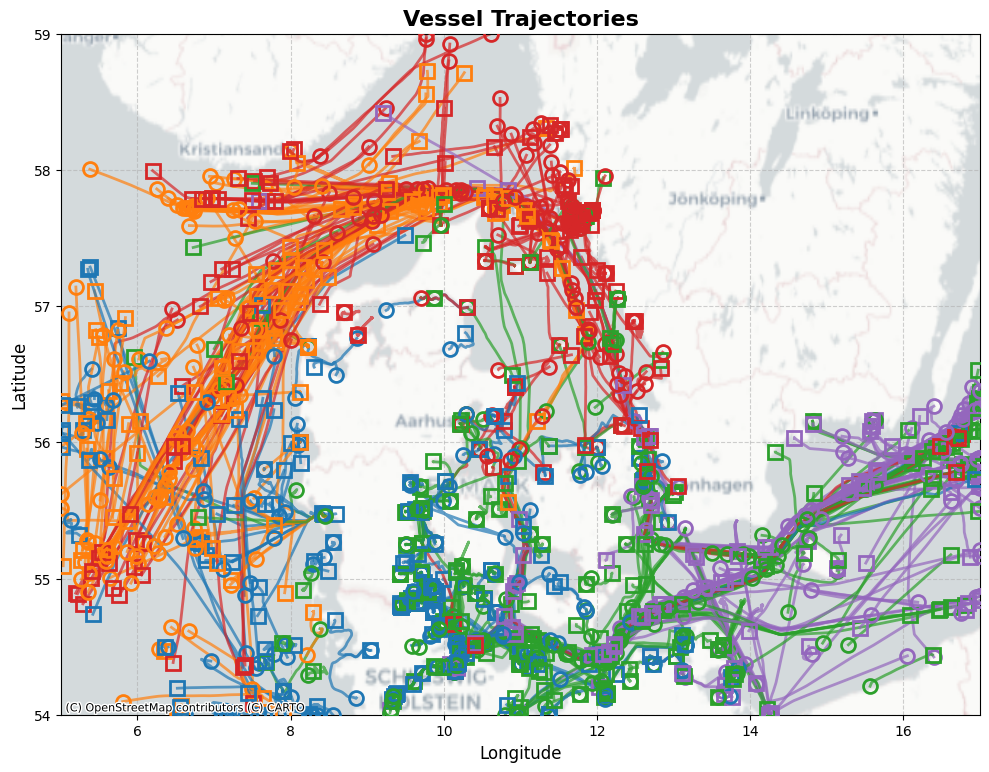

In [23]:
# Example usage, simple KMeans
from sklearn.cluster import KMeans
from src.utils.plot import plot_trajectories
from matplotlib import colormaps as cm

num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(all_cls_vectors) # Fit on CLS vectors
cluster_labels = kmeans.labels_ # Labels 0, 1, ..., num_clusters-1
mmsi_cluster_mapping = {mmsi.item(): int(label) for mmsi, label in zip(all_mmsi, cluster_labels)} # Map MMSI to cluster label

color_map = cm.get_cmap('tab10').colors

tracks_to_plot = []
for i in range(len(ds)):
    track, _, mmsi, _ = ds[i]
    cluster_label = mmsi_cluster_mapping[mmsi.item()]
    color = color_map[cluster_label]
    tracks_to_plot.append({'track': track, 'color': color})
plot_trajectories(tracks_to_plot) # Helper function to plot multiple trajectories

## References
D. Nguyen, R. Fablet. "A Transformer Network With Sparse Augmented Data Representation and Cross Entropy Loss for AIS-Based Vessel Trajectory Prediction," in IEEE Access, vol. 12, pp. 21596–21609, 2024.

Jacob Devlin, et al. "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding," in CoRR, vol. abs/1810.04805, 2018.

Yinhan Liu, et al. "RoBERTa: A Robustly Optimized BERT Pretraining Approach," in CoRR, vol. abs/1907.11692, 2019.